In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import re
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, UpSampling2D
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def create_generator(input_dim, hidden_dim):
    inputs = Input(shape=(input_dim[0], input_dim[1], input_dim[2]))


    x = Conv2D(filters=hidden_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = Conv2D(filters=hidden_dim//2, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)


    x = Conv2D(filters=hidden_dim//2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=hidden_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    outputs = Conv2D(filters=input_dim[2], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear')(x)

    generator = Model(inputs, outputs)
    return generator

In [4]:
def create_discriminator(input_dim, hidden_dim):
    inputs = Input(shape=(input_dim[0], input_dim[1], input_dim[2]))

    # Encoder
    x = Conv2D(filters=hidden_dim//2, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = Conv2D(filters=hidden_dim, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(hidden_dim, activation='relu')(x)

    # Output layer with Conv2D and reshape
    x = Dense(24*24, activation='sigmoid')(x)
    outputs = Reshape((24, 24,1))(x)

    discriminator = Model(inputs, outputs)
    return discriminator

In [5]:
def create_gan(generator, discriminator):
    generator_input = Input(shape=(24, 24, 1))  # Replace 'channels' with the number of image channels (e.g., 1 for grayscale, 3 for RGB)

    discriminator.trainable = False

    masked_data = generator(generator_input)

    valid = discriminator(masked_data)

    gan = Model(generator_input, [masked_data, valid])
    gan.compile(loss=[ 'mse','sparse_categorical_crossentropy'], loss_weights=[100, 10], optimizer=Adam())

    return gan

In [6]:
def preprocess_data(samples):
    mask = np.isnan(samples)
    imputed_samples = samples.copy()
    imputed_samples[mask] = np.random.normal(0, 1, size=np.sum(mask))
    return imputed_samples

In [7]:
def training(data,missing_mask):

    imputed_data = preprocess_data(data)
    data1 = np.where(np.isnan(data), 0, data)
    input_dim = data1[0].shape
    hidden_dim = 300
    alpha = 10
    iterations = 1000
    batch_size = 32

    # Create generator and discriminator
    generator = create_generator(input_dim, hidden_dim)
    discriminator = create_discriminator(input_dim, hidden_dim)

    gan = create_gan(generator, discriminator)

    discriminator.compile(loss='categorical_crossentropy', optimizer=Adam())
    gan.compile(loss=['mse','categorical_crossentropy'], loss_weights=[100,10], optimizer=Adam())
    for iteration in range(iterations):
        # Generate random indices for the batch
        idx = np.random.randint(0, len(data), batch_size)
        real_samples = data1[idx]
        imputed_samples = imputed_data[idx]
        masks = missing_mask[idx]

        generated_data = generator.predict(real_samples,verbose=0)
        real_data = real_samples * masks + generated_data * (1 - masks)
        discriminator.trainable = True

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 24, 24,1)))
        d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 24, 24,1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator.trainable = False

        valid_labels = np.ones((batch_size, 24, 24))
        g_loss = gan.train_on_batch(real_samples, [real_data, valid_labels])

        if iteration%100 == 0:
          print(f"Iteration: {iteration+1}/{iterations} | Disc Loss: {d_loss} | Gen Loss: {g_loss}")
    imputedvalues = generator.predict(data1)
    return imputedvalues

In [8]:
def set_values_to_nan(array, probability):
    # Generate a random mask with the specified probability
    mask = np.random.rand(*array.shape) < probability

    # Set the corresponding values in the array to NaN
    array[mask] = np.nan
    return array,1-mask

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Total Data

In [10]:
directory = '/content/drive/MyDrive/7150 Data Science Final/pictureNS/data'

sample_names_img = [
    filename for filename in os.listdir(directory)
    if os.path.isfile(os.path.join(directory, filename)) and os.path.splitext(filename)[1] == '.png'
]
sample_names = [
    filename for filename in os.listdir(directory)
    if os.path.isfile(os.path.join(directory, filename)) and os.path.splitext(filename)[1] == '.txt'
]
directory = '/content/drive/MyDrive/7150 Data Science Final/pictureNS/data'

X = np.empty((1,24,24))
for sample_name in sample_names:
    index = int(re.findall(r'_(.*?)_', sample_name)[0])
#     img_path=os.path.join(directory,sample_name)
    img_path = directory+"/"+sample_name
    # print(img_path)
    img=np.loadtxt(img_path)
    # print(img)
#     img = img.reshape((24,24,1))
    # print(img)
    X = np.concatenate((X,[img]))

In [11]:
data = X.copy()/255
missing_data,mask = set_values_to_nan(data,.2)
X= np.resize(X,(742,24,24,1))
missing_data = np.resize(missing_data,(742,24,24,1))
mask = np.resize(mask, (742,24,24,1))

In [12]:
imputed_values= training(missing_data,mask)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 24, 24, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


Iteration: 1/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [787.2201538085938, 0.24487321078777313, 76.27328491210938]
Iteration: 101/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.83203125, 0.0008963530417531729, 76.27423858642578]
Iteration: 201/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.79541015625, 0.0005305854137986898, 76.27423858642578]
Iteration: 301/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.7902221679688, 0.00047877131146378815, 76.27423858642578]
Iteration: 401/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.78564453125, 0.00043297893716953695, 76.27423858642578]
Iteration: 501/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.7875366210938, 0.00045248153037391603, 76.27423095703125]
Iteration: 601/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.7831420898438, 0.000408859719755128, 76.27422332763672]
Iteration: 701/1000 | Disc Loss: 5.960465188081798e-08 | Gen Loss: [762.7831420898438, 0.0004076327022630721

In [13]:
imputed = imputed_values[mask==0]*255

In [14]:
np.isnan(imputed).sum()

0

In [15]:
actualvalues = X[mask==0]

In [16]:
actualvalues

array([6.90314591e-310, 4.94065646e-324, 1.48219694e-323, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [17]:
mae = mean_absolute_error(actualvalues, imputed)
rmse = np.sqrt(mean_squared_error(actualvalues, imputed))
r2 = r2_score(actualvalues,imputed)
print("Evaluation\n","MAE : ",mae," | RMSE : ",rmse," | R2 : ",r2)

Evaluation
 MAE :  5.102497127157041  | RMSE :  8.554079056472144  | R2 :  0.9451831431578608


In [1]:
arg = np.argsort(actualvalues)


NameError: ignored

In [ ]:
len(arg)

85475

In [ ]:
l

In [ ]:
len(actualvalues)

85475

<BarContainer object of 85200 artists>

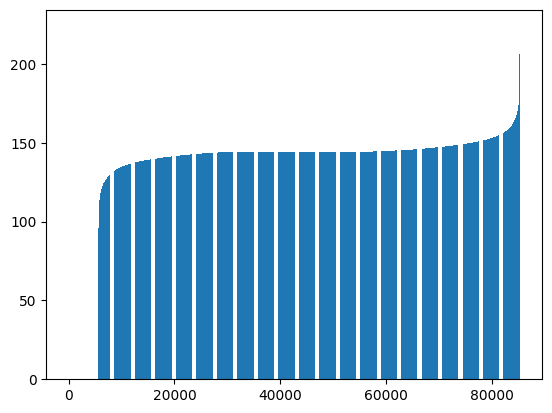

In [ ]:
plt.bar(range(len(actualvalues)),actualvalues[arg])

<BarContainer object of 85200 artists>

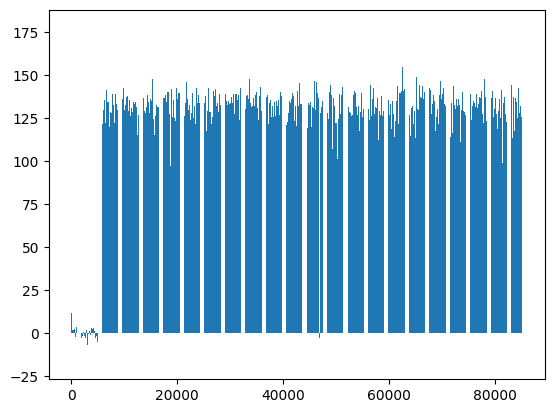

In [ ]:
plt.bar(range(len(imputed)),imputed[arg])

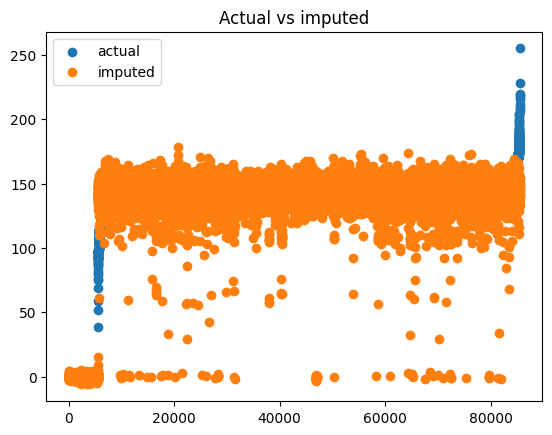

In [ ]:
plt.figure()
plt.title("Actual vs imputed")
plt.scatter(range(len(actualvalues)),actualvalues[arg],label='actual')
plt.scatter(range(len(imputed)),imputed[arg],label="imputed")
plt.legend()
plt.show()

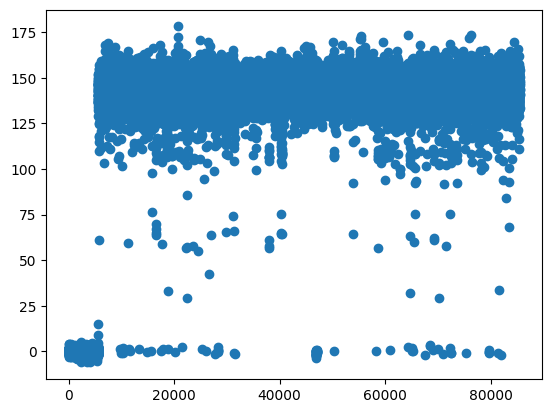

In [ ]:
plt.scatter(range(len(imputed)),imputed[arg],label="imputed")

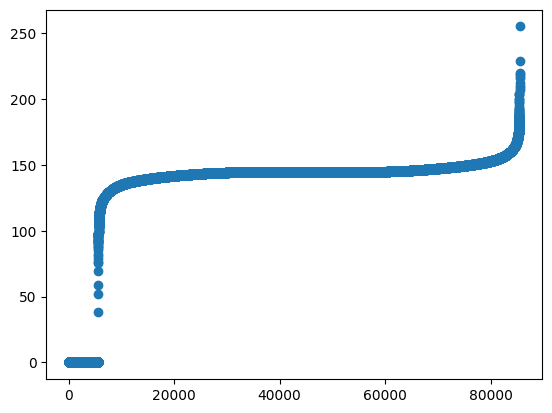

In [ ]:
plt.scatter(range(len(actualvalues)),actualvalues[arg],label='actual')